# **Number classification algorithm**

## **Introduction**

This is the main program that makes different methods of number classification, the study of each algorithm is done in each specific file

## **Image Traitement**

Before using the ML algorithm it must verify that the images that will be used in the classification is in the same format and size as the ones in the database (MNIST)

In [1]:
#Libraries for the image traitement function

import numpy as np
import matplotlib.pyplot as plt
import csv
import cv2 as cv
from scipy import ndimage
import os

In [2]:
# This function is responsable to open all the images obtained by the camera and already processed. 
# The images are transform to be able to compare with the EMNIST database. To do so, basically,
# the function bellow identiify the number in the image, remove this number, insert it in a new image
# in the format of the database and create a file test.cvs to be use by the machine learning's algorithms. 

def image_traitement(image_path):

    # set the parameters to read the images
    image_path_chiffre = image_path # path of the file
    chiffre = image_path_chiffre[-2] # number of the dice

    # list to store all the images in the folder
    image_list = []
    for x in os.listdir(image_path_chiffre):
        path_image = image_path_chiffre + x
        im = cv.imread(path_image, 0)
        image_list.append(im)

    # list with images after the processing
    resized_list = []

    # image processing for each image of the folder
    for im in image_list:

        # convert the color to gray
        imgray = cv.cvtColor(im, cv.COLOR_GRAY2BGR) #for better accuracy, use binary images
        
        # apply the threshold to invert the pixels of the image
        # all pixels value equal to 255 (white) will be set to 0 (black)
        ret, thresh = cv.threshold(im, 225, 255, cv.THRESH_BINARY_INV) #OBS: try change to imgray
        #plt.imshow(im, cmap='gray') # image with the pixels inverted
        
        # calculate all the countors of the image
        # the variable contours contains points of the countors
        contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        
        # loop over the contours points, calculate the area of these points and 
        # chose the first area that is sufficently large
        for i in range(len(contours)):

            # calcul de la zone des contours
            area = cv.contourArea(contours[i])

            # if the contour is sufficiently large, it must be the digit
            if area > 50 and area < 700:
                
                # compute the bounding box where (x,y) is the top-left coordinate of the rectangle 
                # and (w,h) is the width and height
                (x, y, w, h) = cv.boundingRect(contours[i]) # calcul de coordonnes de la zone

                # affiche les rectangles sur l'image binaire
                #cv.rectangle(imgray, (x,y), (x+w,y+h), (255,255,0), 2) 

                # extract the region of interest (ROI) using the informations of the bounding box
                diceROI = thresh[y-2 : y+h+2, x-2 : x+w+2] # extraction de la zone sur l'image    
                #plt.matshow(diceROI, cmap="gray")
                break
                 
        # calculate the center of mass, the height and the width of the ROI
        centre_h, centre_w = ndimage.measurements.center_of_mass(diceROI)
        h, w = diceROI.shape
        
        # create a new image and insert the ROI
        n = 56 # the ROI will be insert in the center of a bigger image
        
        black_image = np.zeros((n,n))
        black_image[int((n-h)/2) : int(((n-h)/2)+h), int((n-w)/2) : int(((n-w)/2)+w)] = diceROI 
        #plt.matshow(black_image, cmap='gray')

        # resize the image to the format 28x28 pixel (format of the database)
        scale_percent = 50 # percent of original size
        
        width = int(black_image.shape[1] * scale_percent / 100)
        height = int(black_image.shape[0] * scale_percent / 100)
        dim = (width, height)

        # resize the image
        resized = cv.resize(black_image, dim, interpolation = cv.INTER_AREA)
        resized_list.append(resized) # add to the list of final images

        # write the pixel matrix in the test.csv file, the row will have 785 columns (28x28 + 1)
        # where the last column is the dice's number
        A = np.asarray(resized).reshape(-1) # shape the matrix to just one line
        
        row = []
        for result in A:
            row.append(result)
        row.append(float(chiffre)) #the last column is the dice's number

        # open the file in the for appending new information (new row)
        with open('initial_test.csv', "a") as file:
            writer = csv.writer(file)
            writer.writerow(row) 

    # print the processed images 
    #print("Dice's number: " + str(chiffre))
    #print("Number of the images in the folder: " + str(len(image_list)))
    #print("Number of the images created: " + str(len(resized_list)))
    #for pos in range(0, len(resized_list)):
    #    plt.matshow(resized_list[pos], cmap='gray')
    '''
    if os.path.isfile('test.csv'):
        print ("END")
    else:
        print ('file does not exist')
    '''

## **Read database**

This part contains the functions to extract the database from the python library and also to extract the information from the csv file.

In [3]:
#Libraries for this second part
from keras.datasets import mnist
import numpy as np
import csv
import matplotlib.pyplot as plt 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
import itertools
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.
/home/morooka/.local/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
#Extract the numbers from database

def selectDiceNumbers(img_list_all, labels_list_all):
    img_final = []
    labels_final = []
    diceNumbers = [1, 2, 3, 4, 5, 6]

    if len(img_list_all) == len(labels_list_all):
        initialSize = range(len(img_list_all))
    else:
        print("Size of lists must be the same!")

    for i in initialSize:
        if (labels_list_all[i] in diceNumbers):
            img_final.append(img_list_all[i])
            labels_final.append(labels_list_all[i])
    
    return img_final, labels_final

def load_datasets():
    print("Loading Training dataset and Testing dataset...")
    (img_train_all, labels_train_all),(img_test_all, labels_test_all) = mnist.load_data()
    
    img_train, labels_train = selectDiceNumbers(img_train_all, labels_train_all)
    img_test, labels_test = selectDiceNumbers(img_test_all, labels_test_all)

    print("Finished loading!")
    
    return img_train, labels_train, img_test, labels_test

    
X_train, Y_train, X_test, Y_test = load_datasets()
#Train dataset size = 36012
#Test dataset size = 6009

Loading Training dataset and Testing dataset...
Finished loading!


In [5]:
def read_test():    
    image = []
    labels = []
    with open('initial_test.csv', 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter = ',', quotechar = '|', quoting = csv.QUOTE_NONNUMERIC)
        for line in spamreader:
            image.append(np.array(line[:-1]))
            labels.append(line[-1])
    
    return image, labels

In [6]:
def create_number_list(data):
    images = []
    for x in data:
        images.append(x.reshape(-1))
#        number = []
#        for y in x:
#            for pixel in y:
#                number.append(pixel)
#        images.append(number)

    return images

In [7]:
def plot_confusion_matrix(clf, data_x, data_y):
    classes = ['1', '2', '3', '4', '5', '6']

    Ypred = clf.predict(data_x)
    
    # Computation of confusion matrix on testing set
    cm = confusion_matrix(data_y, Ypred)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [8]:
def tuning_parameter(start_value, end_value, N, model):
    # Model training and accuracy computation for different parameters
    values = [i for i in range(start_value, end_value)]
    accs_train = []
    accs_test  = []

    # Train on the first N train images
    train_x = create_number_list(X_train[:N])
    train_y = np.array(Y_train[:N])

    # Test on the next N/6 test images:
    test_x = create_number_list(X_test[:N/6])
    test_y = np.array(Y_test[:N/6]) 
    
    for i in values:
        if model == 1:
            clf = KNeighborsClassifier(n_neighbors=i)
        elif model == 2:
            clf = DecisionTreeClassifier(random_state = 0, max_depth = i)
        elif model == 3:
            clf = RandomForestClassifier(n_estimators=i)
        elif model == 4:
            clf = svm.LinearSVC(random_state=0)
        clf.fit(train_x, train_y)
        accs_train.append(clf.score(train_x, train_y))
        accs_test.append(clf.score(test_x, test_y))
    plt.figure(figsize=(16, 8))

    # Draw accuracies as a function of the depth for both trainin and testing sets
    if model == 1:
        plt.title("KNN")
    elif model == 2:
        plt.title("Decision Tree Classifier")
    elif model == 3:
        plt.title("Random Forest Classifier")
    elif model == 4:
        plt.title("Support Vector Machine")    
    plt.plot(values, accs_train, label = 'Train Accuracy')
    plt.plot(values, accs_test,  label = 'Test Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Parameter')
    plt.legend()
    plt.xticks(values)
    plt.show()  

In [9]:
def model_evaluation(N, model):
    # Create the classifier using the scikit learn library
    if model == 1:
        modelName = "KK neighbors"
        clf = KNeighborsClassifier(n_neighbors=10)
    elif model == 2:
        modelName = "Decision Tree"
        clf = DecisionTreeClassifier(random_state = 0, max_depth = 20)
    elif model == 3:
        modelName = "Random Forest"
        clf = RandomForestClassifier(n_estimators=100)
    elif model == 4:
        modelName = "Support Vector Machine"
        clf = svm.LinearSVC(random_state=0)

    print("Analysing " + modelName + " model")
    
    # Train on the first N train images
    train_x = create_number_list(X_train[:N])
    train_y = np.array(Y_train[:N])

    # Test on the next N/6 test images:
    test_x = create_number_list(X_test[:N/6])
    test_y = np.array(Y_test[:N/6]) 
    
    #Train the classifier
    clf.fit(train_x, train_y)
    
    #New set of values
    test_x_photos, test_y_photos = read_test()
    
    print("Using: " + str(N) + " images from database")
    print("Using: " + str(len(test_x_photos)) + " photos taken")
      
    #Predict the results of the test dataset
    predicted = clf.predict(test_x)
    predicted_photos = clf.predict(test_x_photos)
    print("The accuracy for the test database is: " + str(round((accuracy_score(test_y, predicted) * 100), 3)) + "%")
    print("The accuracy for the photos taken is: " + str(round((accuracy_score(test_y_photos, predicted_photos) * 100), 3)) + "%")

    
    #Plot confusion matrix for analyse the classification
    plt.figure(figsize=(12,6))

    plt.subplot(121)
    plt.title("Confusion Matrix for test database")
    plot_confusion_matrix(clf, test_x, test_y)
    
    plt.subplot(122)
    plt.title("Confusion Matrix Photos taken")
    plot_confusion_matrix(clf, test_x_photos, test_y_photos)
    plt.show()

# **Main for executing the analysis**

This is the main that executes the functions defined above

In [10]:
import os
import sys

def main(model, N):
    
    valid_models = [1, 2, 3, 4]

    if model not in valid_models:
        print("MODEL VALUE MUST BE 1,2,3,4")
        sys.exit()
    
    if N > 36012:
        print("N VALUE MUST BE SMALLER THAN 36012")
        sys.exit()
        
    img1 = os.getcwd() + '/chiffres/Numero1/'
    img2 = os.getcwd() + '/chiffres/Numero2/'
    img3 = os.getcwd() + '/chiffres/Numero3/'
    img4 = os.getcwd() + '/chiffres/Numero4/'
    img5 = os.getcwd() + '/chiffres/Numero5/'
    img6 = os.getcwd() + '/chiffres/Numero6/'        
        
    if os.path.isfile('initial_test.csv'):
        os.remove('initial_test.csv')
    else:
        print 'Test file does not exist'
            
    for image in [img1, img2, img3, img4, img5, img6]:
        image_traitement(image)

    if os.path.isfile('initial_test.csv'):
        print "Created test file"
    else:
        print 'Test file does not exist'

    model_evaluation(N, model)

Test file does not exist
Created test file
Analysing KK neighbors model
Using: 2000 images from database
Using: 188 photos taken
The accuracy for the test database is: 90.39%
The accuracy for the photos taken is: 35.106%


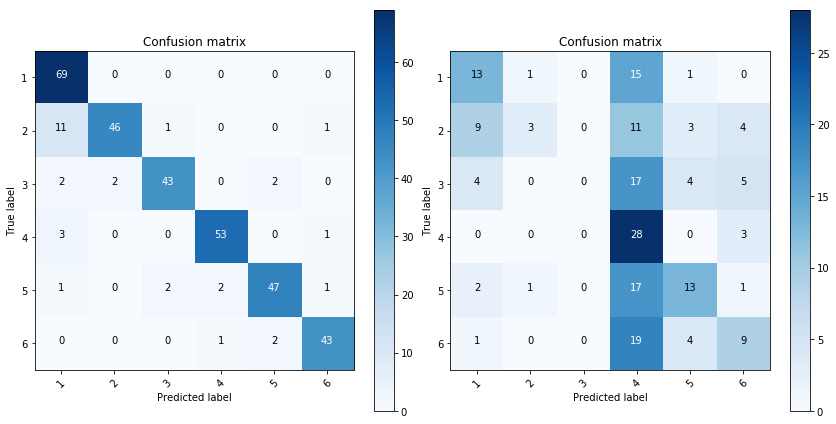

In [11]:
# Fist argument is the model (1 to 4 models)
# 1 ==> Decision Tree Classifier
# 2 ==> KK neighbors Classifier
# 3 ==> Random Forest Classifier
# 4 ==> SVM Classifier

#Second argument is the number of numbers analysed, it must be smaller than 36012
main(1, 2000)

Created test file
Analysing Decision Tree model
Using: 2000 images from database
Using: 38 photos taken
The accuracy for the test database is: 75.075%
The accuracy for the photos taken is: 44.737%


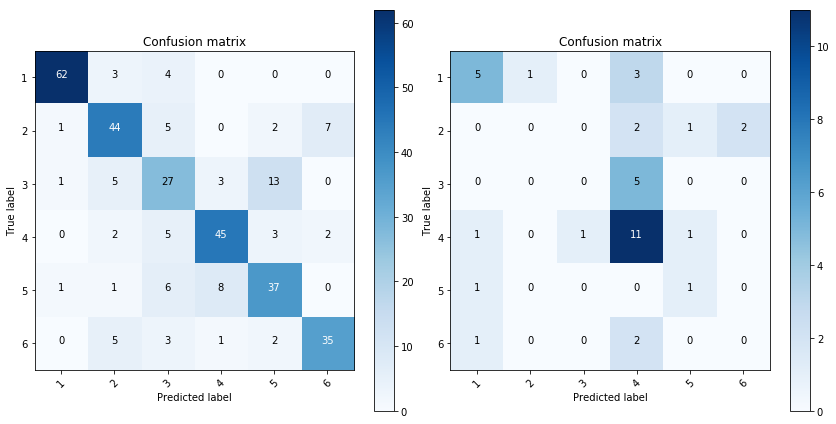

In [37]:
# Fist argument is the model (1 to 4 models)
# 1 ==> Decision Tree Classifier
# 2 ==> KK neighbors Classifier
# 3 ==> Random Forest Classifier
# 4 ==> SVM Classifier

#Second argument is the number of numbers analysed, it must be smaller than 36012
main(2, 2000)

Created test file
Analysing Random Forest model
Using: 6000 images from database
Using: 188 photos taken
The accuracy for the test database is: 95.5%
The accuracy for the photos taken is: 29.787%


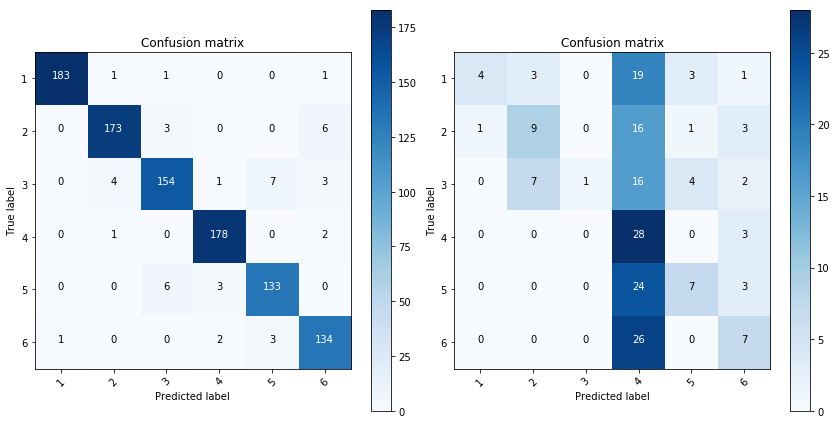

In [15]:
# Fist argument is the model (1 to 4 models)
# 1 ==> Decision Tree Classifier
# 2 ==> KK neighbors Classifier
# 3 ==> Random Forest Classifier
# 4 ==> SVM Classifier

#Second argument is the number of numbers analysed, it must be smaller than 36012
main(3, 6000)